## Imports

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
print(sys.path[-1]) 


import rasterio
import numpy as np
from Ortomosaicos import load_orthomosaics, list_orthomosaics, show_orthomosaic
from Normalizacion import (
    get_reference_profile,
    align_all_campaigns,
    normalize_all
)

d:\Programas Python\Trabajo Final\Trabajo-Final\src


## Lista de archivos

In [2]:
list_orthomosaics("10ene")
list_orthomosaics("17ene")
list_orthomosaics("24ene")


📂 Ortomosaicos disponibles para 10ene:

  - estanzuela_10ene_MS_orthophoto.tif
  - estanzuela_10ene_NIR_orthophoto.tif
  - estanzuela_10ene_RED_orthophoto.tif
  - estanzuela_10ene_rgb_orthophoto.tif

📂 Ortomosaicos disponibles para 17ene:

  - Octavio-Vergara-1-17-2025-dsm.tif
  - Octavio-Vergara-1-17-2025-georeferenced_model.laz
  - estanzuela_17ene_MS_orthophoto.tif
  - estanzuela_17ene_NIR_orthophoto.tif
  - estanzuela_17ene_RED_orthophoto.tif
  - estanzuela_17ene_rgb_orthophoto.tif

📂 Ortomosaicos disponibles para 24ene:

  - Octavio-Vergara-1-24-2025-dsm.tif
  - estanzuela_24ene_MS_orthophoto.tif
  - estanzuela_24ene_NIR_orthophoto.tif
  - estanzuela_24ene_RED_orthophoto.tif
  - estanzuela_24ene_rgb_orthophoto.tif


## EDA

### Carga de ortomosaicos

In [3]:
ortomosaicos_10 = load_orthomosaics("10ene")
ortomosaicos_17 = load_orthomosaics("17ene")
ortomosaicos_24 = load_orthomosaics("24ene")

datasets = {
    "10ene": ortomosaicos_10,
    "17ene": ortomosaicos_17,
    "24ene": ortomosaicos_24
}

# Tipos de ortomosaicos a comparar
tipos = ["rgb", "red", "nir", "ms"]

### Función de extracción de metadatos

In [4]:
# ### Función auxiliar: extrae metadatos (forma, canales, tipo de dato)

def get_metadata(path_or_array):
    """
    Devuelve un diccionario con (shape, canales, dtype) de un ortomosaico.
    """
    if isinstance(path_or_array, str) and os.path.exists(path_or_array):
        with rasterio.open(path_or_array) as src:
            shape = (src.height, src.width)
            count = src.count
            dtype = src.dtypes[0]
    elif isinstance(path_or_array, np.ndarray):
        count, height, width = path_or_array.shape
        shape = (height, width)
        dtype = path_or_array.dtype
    else:
        return None
    return {"shape": shape, "channels": count, "dtype": dtype}


### Comparación de metadatos por tipo

In [5]:
# %% [markdown]
# ### Comparación de metadatos por tipo de ortomosaico

# %%
from pprint import pprint

for tipo in tipos:
    print(f"\n🔹 {tipo.upper()} — comparación entre campañas")
    info = {}
    for fecha, dataset in datasets.items():
        if dataset[tipo] is not None:
            info[fecha] = get_metadata(dataset[tipo])
        else:
            info[fecha] = "❌ No encontrado"
    pprint(info)



🔹 RGB — comparación entre campañas
{'10ene': {'channels': 4, 'dtype': dtype('uint8'), 'shape': (1850, 2875)},
 '17ene': {'channels': 4, 'dtype': dtype('uint8'), 'shape': (1947, 2799)},
 '24ene': {'channels': 4, 'dtype': dtype('uint8'), 'shape': (1990, 3009)}}

🔹 RED — comparación entre campañas
{'10ene': {'channels': 2, 'dtype': dtype('uint16'), 'shape': (1553, 2719)},
 '17ene': {'channels': 2, 'dtype': dtype('uint16'), 'shape': (1517, 2724)},
 '24ene': {'channels': 2, 'dtype': dtype('uint16'), 'shape': (1517, 2788)}}

🔹 NIR — comparación entre campañas
{'10ene': {'channels': 2, 'dtype': dtype('uint16'), 'shape': (1633, 2871)},
 '17ene': {'channels': 2, 'dtype': dtype('uint16'), 'shape': (1475, 2723)},
 '24ene': {'channels': 2, 'dtype': dtype('uint16'), 'shape': (1552, 2784)}}

🔹 MS — comparación entre campañas
{'10ene': {'channels': 5, 'dtype': dtype('float32'), 'shape': (607, 1110)},
 '17ene': {'channels': 5, 'dtype': dtype('float32'), 'shape': (621, 1090)},
 '24ene': {'channels': 5

## Normalización

### Normalización espacial

Para asegurar comparabilidad entre campañas, se adopta como referencia espacial el **ortomosaico multiespectral del 17 de enero**.  
Aunque posee menor resolución (menos píxeles) que los RGB, es el producto **más estable y calibrado radiométricamente**, lo que garantiza coherencia física entre fechas.  

Las demás capas (RGB, NIR, RED, MS de otras fechas) se re-muestrearán a su misma grilla, resolución y sistema de coordenadas.

El ortomosaico está georreferenciado en metros, dentro de la proyección UTM 21 Sur.
Gracias a eso, los píxeles se alinean correctamente entre campañas y se pueden superponer con otras capas (como parcelas, DSM, etc.).


#### Referencia espacial (MS 17/ene)

Qué hace: abre el multiespectral del 17 de enero y guarda su perfil (CRS, transform, width/height).
Por qué: esa será la “grilla” a la que vamos a llevar todo lo demás.

In [6]:
# %% [markdown]
# #### Referencia espacial (MS 17/ene)
# 
# Qué hace:
# - Obtiene automáticamente el perfil de referencia desde el ortomosaico multiespectral (MS) del 17/ene.
# - Este perfil (CRS, transform, ancho, alto, etc.) se usará para alinear todas las demás imágenes.

# %%
# Paso 0.1 — Obtener la grilla de referencia usando el módulo Normalizacion
# -------------------------------------------------------------------------
# La función get_reference_profile() carga el ortomosaico MS del 17/ene
# y extrae su perfil completo con metadatos espaciales.

REF_PROFILE = get_reference_profile("17ene")


Referencia espacial: estanzuela_17ene_MS_orthophoto.tif
CRS: EPSG:32721
Dims: 621 x 1090


#### Alineación espacial

In [7]:
# %% [markdown]
# #### Alineación espacial
# 
# Qué hace:
# - Re-muestrea todos los ortomosaicos (10ene, 17ene, 24ene) a la grilla del MS 17/ene.
# - Garantiza mismo tamaño, resolución y sistema de coordenadas (CRS).
# - Usa el método de interpolación bilinear para datos continuos (imágenes).

# %%
# Paso 0.2 — Alinear todos los ortomosaicos a la grilla del MS 17/ene
# ---------------------------------------------------------------------
# La función align_all_campaigns() del módulo Normalizacion realiza todo el proceso:
#  - Obtiene las rutas de cada ortomosaico con load_orthomosaics().
#  - Aplica align_to_reference() internamente (basado en rasterio.WarpedVRT).
#  - Devuelve un diccionario 'aligned' con todos los ortomosaicos re-muestreados.

aligned = align_all_campaigns(datasets, REF_PROFILE)

# Chequeo rápido: todas las campañas deben compartir el mismo alto y ancho.
for tipo in ["rgb", "red", "nir", "ms"]:
    formas = {
        fecha: (None if aligned[fecha][tipo] is None else aligned[fecha][tipo].shape)
        for fecha in aligned.keys()
    }
    print(f"{tipo.upper()} ->", formas)


RGB -> {'10ene': (4, 621, 1090), '17ene': (4, 621, 1090), '24ene': (4, 621, 1090)}
RED -> {'10ene': (2, 621, 1090), '17ene': (2, 621, 1090), '24ene': (2, 621, 1090)}
NIR -> {'10ene': (2, 621, 1090), '17ene': (2, 621, 1090), '24ene': (2, 621, 1090)}
MS -> {'10ene': (5, 621, 1090), '17ene': (5, 621, 1090), '24ene': (5, 621, 1090)}


#### Visualización


🖼️ Mostrando ortomosaicos alineados: RGB


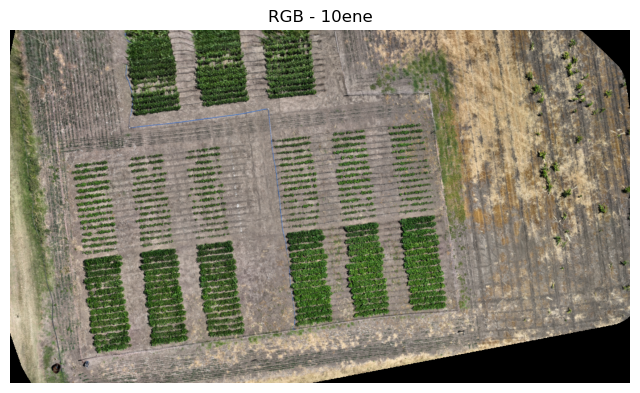

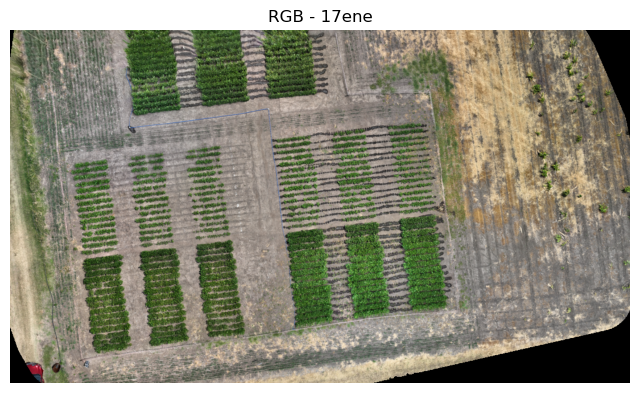

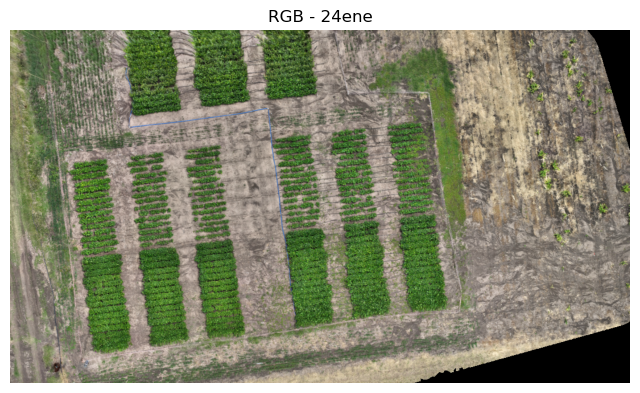


🖼️ Mostrando ortomosaicos alineados: RED


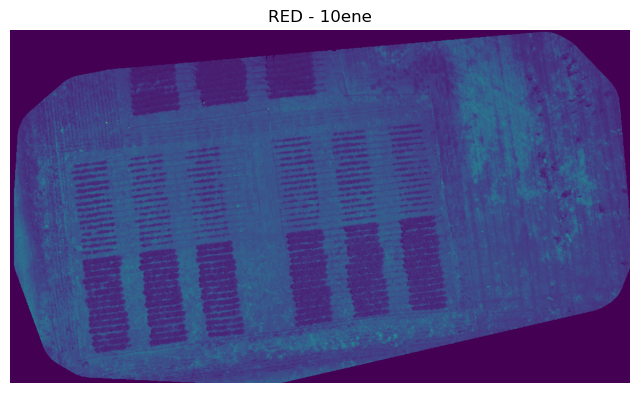

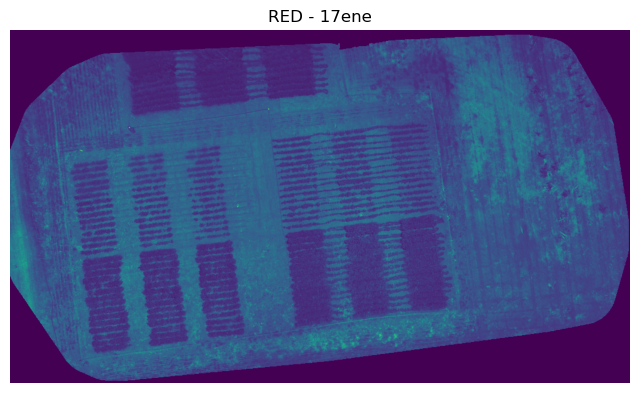

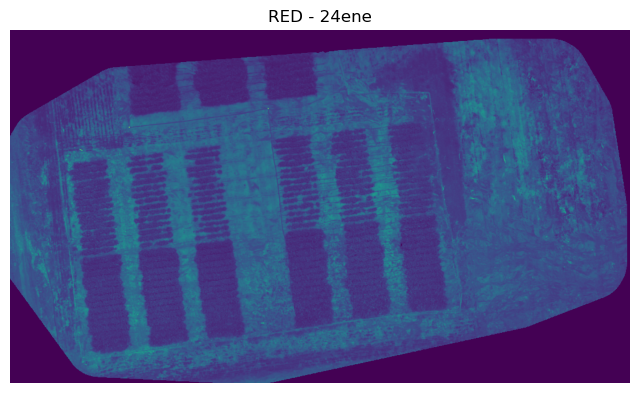


🖼️ Mostrando ortomosaicos alineados: NIR


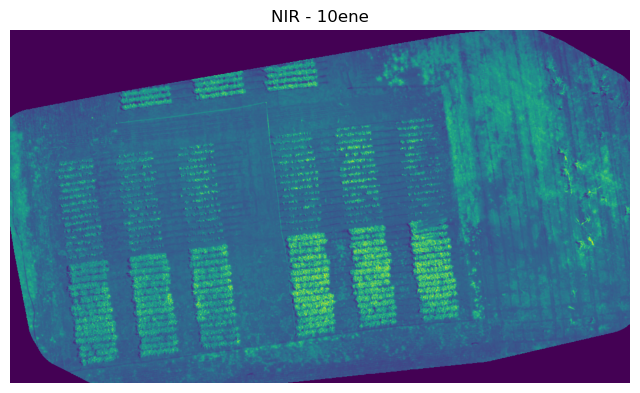

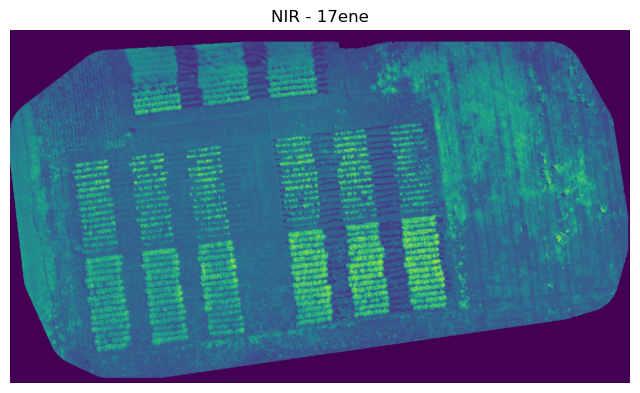

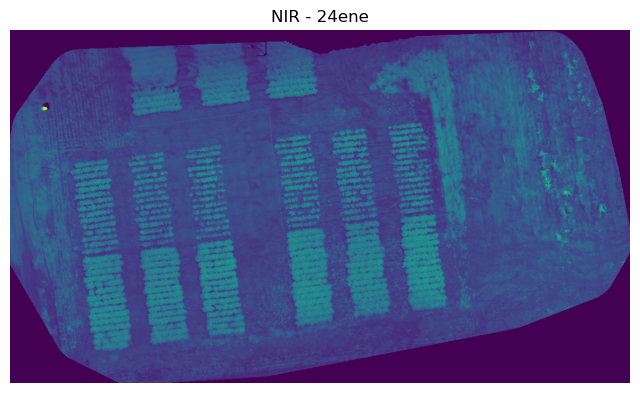

In [8]:
# Paso 0.3 — Visualización de ortomosaicos alineados
# -----------------------------------------------------------------------------
# Qué hace:
#  - Usa show_orthomosaic para mostrar las imágenes alineadas (ya con misma grilla).
#  - Permite verificar visualmente que todas las campañas estén correctamente superpuestas.
#  - Se recomienda revisar que el encuadre y orientación coincidan entre fechas.

for tipo in ["rgb", "red", "nir"]:
    print(f"\n🖼️ Mostrando ortomosaicos alineados: {tipo.upper()}")
    for fecha in ["10ene", "17ene", "24ene"]:
        img = aligned[fecha][tipo]
        if img is not None:
            show_orthomosaic(img, title=f"{tipo.upper()} - {fecha}")
        else:
            print(f"⚠️ No se encontró {tipo} para {fecha}")


### Normalización radiométrica

Una vez alineadas espacialmente, las imágenes aún difieren en su **escala de valores** (radiometría):
- Los ortomosaicos RGB suelen estar en enteros de 8 bits → valores de 0 a 255.
- Los ortomosaicos multiespectrales (RED, NIR, MS) suelen usar 16 bits o flotantes → valores mucho mayores.

Para poder compararlas y combinarlas (por ejemplo, al calcular índices como NDVI o al entrenar un modelo),  
es necesario **llevar todos los valores a un rango común [0, 1]**, convirtiendo a `float32`.

Esto no altera la forma de la imagen, solo **ajusta su escala** para que todas las bandas sean coherentes entre sí.


In [9]:
# %% [markdown]
# #### Normalización radiométrica
# 
# Qué hace:
# - Escala los valores digitales de todos los ortomosaicos al rango [0, 1].
# - Asegura coherencia radiométrica entre sensores y fechas.
# - Utiliza la función normalize_all() del módulo Normalizacion.

# %%
# Paso 1.2 — Aplicar la normalización radiométrica a todos los ortomosaicos
# -------------------------------------------------------------------------
# La función normalize_all() recorre internamente 'aligned' y aplica
# normalize_radiometric() a cada tipo de ortomosaico (rgb, red, nir, ms).

normalized = normalize_all(aligned)

# Control: mostramos el rango de valores de cada tipo y fecha.
for tipo in ["rgb", "red", "nir", "ms"]:
    print(f"\n🔹 {tipo.upper()} — rango de valores normalizados:")
    for fecha in ["10ene", "17ene", "24ene"]:
        arr = normalized[fecha][tipo]
        if arr is not None:
            print(f"  {fecha}: min={np.nanmin(arr):.3f}, max={np.nanmax(arr):.3f}")
        else:
            print(f"  {fecha}: ❌ No encontrado")



🔹 RGB — rango de valores normalizados:
  10ene: min=0.000, max=1.000
  17ene: min=0.000, max=1.000
  24ene: min=0.000, max=1.000

🔹 RED — rango de valores normalizados:
  10ene: min=0.000, max=1.000
  17ene: min=0.000, max=1.000
  24ene: min=0.000, max=1.000

🔹 NIR — rango de valores normalizados:
  10ene: min=0.000, max=1.000
  17ene: min=0.000, max=1.000
  24ene: min=0.000, max=1.000

🔹 MS — rango de valores normalizados:
  10ene: min=-0.000, max=1.000
  17ene: min=-0.000, max=1.000
  24ene: min=-0.000, max=1.000


## Segmentación 

### Baseline - Otsu

Requiere: módulos de "Normalizacion" y "Ortomosaicos" ya cargados (HU1).
Entradas: diccionarios 'aligned' y 'normalized' (salidas de HU1).
Salidas de HU2:
 - 'masks': máscaras binarias (parcelas=1, no-parcelas=0) por fecha/tipo.
 - 'overlays': RGB con máscara superpuesta (para inspección visual rápida).


In [13]:
import numpy as np
import scipy.ndimage as ndi  # para etiquetado de componentes y morfología
import matplotlib.pyplot as plt
from typing import Dict, Tuple

In [14]:
# %% [markdown]
# Función auxiliar: tomar un canal (1 banda) desde un array (C,H,W)
# Si el ortomosaico tiene más de una banda, por defecto usamos la 1ra.
# Si es RGB/MS y se desea un índice, más abajo dejamos hooks.

def first_band(arr: np.ndarray) -> np.ndarray:
    """
    Devuelve la primera banda de un ortomosaico (C,H,W) como float32.
    Maneja None y arrays 2D (ya monocanal).
    """
    if arr is None:
        return None
    if arr.ndim == 2:
        return arr.astype("float32")
    if arr.ndim == 3:
        return arr[0].astype("float32")
    raise ValueError("Array con dimensiones inesperadas.")


In [15]:
# %% [markdown]
# Implementación simple de Otsu (sin scikit-image / OpenCV)

def otsu_threshold(img: np.ndarray, nbins: int = 256) -> float:
    """
    Calcula el umbral de Otsu sobre img (float32 o similar).
    nbins define la discretización del histograma.
    """
    finite = np.isfinite(img)
    data = img[finite]
    if data.size == 0:
        return 0.0

    vmin, vmax = float(data.min()), float(data.max())
    if vmax <= vmin:
        return vmin

    hist, bin_edges = np.histogram(data, bins=nbins, range=(vmin, vmax))
    hist = hist.astype(np.float64)
    probs = hist / hist.sum()

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) * 0.5
    w_cum = np.cumsum(probs)
    mu_cum = np.cumsum(probs * bin_centers)
    mu_total = mu_cum[-1]

    # Varianza entre clases: sigma_b^2 = (mu_T * w - mu)^2 / (w * (1 - w))
    numerator = (mu_total * w_cum - mu_cum) ** 2
    denominator = w_cum * (1.0 - w_cum)
    with np.errstate(divide="ignore", invalid="ignore"):
        sigma_b2 = numerator / denominator
    sigma_b2[~np.isfinite(sigma_b2)] = -1.0

    k = np.argmax(sigma_b2)
    return float(bin_centers[k])


In [16]:
# %% [markdown]
# Segmentación baseline por fecha/tipo con Otsu sobre NIR (o RED si NIR falta).

def segment_parcels_baseline(
    normalized: Dict[str, Dict[str, np.ndarray]],
    fechas = ("10ene", "17ene", "24ene"),
    tipos_base = ("nir", "red"),   # preferimos NIR; si falta, usamos RED
    gauss_sigma: float = 1.5,
    min_blob_area_ratio: float = 1e-4,
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Devuelve máscaras binarias por fecha (clave 'mask') y un 'base' indicando qué canal se usó.
    min_blob_area_ratio: umbral relativo para filtrar blobs diminutos (relativo a H*W).
    """
    masks = {f: {} for f in fechas}

    for fecha in fechas:
        # elegimos canal base disponible
        base_arr = None
        base_tipo = None
        for t in tipos_base:
            cand = normalized.get(fecha, {}).get(t)
            if cand is not None:
                base_arr = first_band(cand)
                base_tipo = t
                break

        if base_arr is None:
            masks[fecha]["mask"] = None
            masks[fecha]["base"] = None
            continue

        # 1) Suavizado
        img = ndi.gaussian_filter(base_arr, sigma=gauss_sigma)

        # 2) Otsu
        thr = otsu_threshold(img)
        mask = (img >= thr).astype(np.uint8)

        # 3) Morfología: quite de ruido y cierre de huecos
        mask = ndi.binary_opening(mask, structure=np.ones((3,3))).astype(np.uint8)
        mask = ndi.binary_closing(mask, structure=np.ones((5,5))).astype(np.uint8)

        # 4) Filtrado por área mínima relativa
        h, w = mask.shape
        lbl, num = ndi.label(mask)
        if num > 0:
            areas = ndi.sum(mask, lbl, index=np.arange(1, num+1))
            keep = (areas >= (min_blob_area_ratio * h * w))
            cleaned = np.zeros_like(mask)
            # map etiquetas a keep
            for i, k in enumerate(keep, start=1):
                if k:
                    cleaned[lbl == i] = 1
            mask = cleaned

        masks[fecha]["mask"] = mask.astype(np.uint8)
        masks[fecha]["base"]  = base_tipo

    return masks


In [17]:
# %% [markdown]
# Función auxiliar: tomar un canal (1 banda) desde un array (C,H,W)
# Si el ortomosaico tiene más de una banda, por defecto usamos la 1ra.
# Si es RGB/MS y se desea un índice, más abajo dejamos hooks.

def first_band(arr: np.ndarray) -> np.ndarray:
    """
    Devuelve la primera banda de un ortomosaico (C,H,W) como float32.
    Maneja None y arrays 2D (ya monocanal).
    """
    if arr is None:
        return None
    if arr.ndim == 2:
        return arr.astype("float32")
    if arr.ndim == 3:
        return arr[0].astype("float32")
    raise ValueError("Array con dimensiones inesperadas.")


In [18]:
# %% [markdown]
# Implementación simple de Otsu (sin scikit-image / OpenCV)

def otsu_threshold(img: np.ndarray, nbins: int = 256) -> float:
    """
    Calcula el umbral de Otsu sobre img (float32 o similar).
    nbins define la discretización del histograma.
    """
    finite = np.isfinite(img)
    data = img[finite]
    if data.size == 0:
        return 0.0

    vmin, vmax = float(data.min()), float(data.max())
    if vmax <= vmin:
        return vmin

    hist, bin_edges = np.histogram(data, bins=nbins, range=(vmin, vmax))
    hist = hist.astype(np.float64)
    probs = hist / hist.sum()

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) * 0.5
    w_cum = np.cumsum(probs)
    mu_cum = np.cumsum(probs * bin_centers)
    mu_total = mu_cum[-1]

    # Varianza entre clases: sigma_b^2 = (mu_T * w - mu)^2 / (w * (1 - w))
    numerator = (mu_total * w_cum - mu_cum) ** 2
    denominator = w_cum * (1.0 - w_cum)
    with np.errstate(divide="ignore", invalid="ignore"):
        sigma_b2 = numerator / denominator
    sigma_b2[~np.isfinite(sigma_b2)] = -1.0

    k = np.argmax(sigma_b2)
    return float(bin_centers[k])


In [19]:
# %% [markdown]
# Segmentación baseline por fecha/tipo con Otsu sobre NIR (o RED si NIR falta).

def segment_parcels_baseline(
    normalized: Dict[str, Dict[str, np.ndarray]],
    fechas = ("10ene", "17ene", "24ene"),
    tipos_base = ("nir", "red"),   # preferimos NIR; si falta, usamos RED
    gauss_sigma: float = 1.5,
    min_blob_area_ratio: float = 1e-4,
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Devuelve máscaras binarias por fecha (clave 'mask') y un 'base' indicando qué canal se usó.
    min_blob_area_ratio: umbral relativo para filtrar blobs diminutos (relativo a H*W).
    """
    masks = {f: {} for f in fechas}

    for fecha in fechas:
        # elegimos canal base disponible
        base_arr = None
        base_tipo = None
        for t in tipos_base:
            cand = normalized.get(fecha, {}).get(t)
            if cand is not None:
                base_arr = first_band(cand)
                base_tipo = t
                break

        if base_arr is None:
            masks[fecha]["mask"] = None
            masks[fecha]["base"] = None
            continue

        # 1) Suavizado
        img = ndi.gaussian_filter(base_arr, sigma=gauss_sigma)

        # 2) Otsu
        thr = otsu_threshold(img)
        mask = (img >= thr).astype(np.uint8)

        # 3) Morfología: quite de ruido y cierre de huecos
        mask = ndi.binary_opening(mask, structure=np.ones((3,3))).astype(np.uint8)
        mask = ndi.binary_closing(mask, structure=np.ones((5,5))).astype(np.uint8)

        # 4) Filtrado por área mínima relativa
        h, w = mask.shape
        lbl, num = ndi.label(mask)
        if num > 0:
            areas = ndi.sum(mask, lbl, index=np.arange(1, num+1))
            keep = (areas >= (min_blob_area_ratio * h * w))
            cleaned = np.zeros_like(mask)
            # map etiquetas a keep
            for i, k in enumerate(keep, start=1):
                if k:
                    cleaned[lbl == i] = 1
            mask = cleaned

        masks[fecha]["mask"] = mask.astype(np.uint8)
        masks[fecha]["base"]  = base_tipo

    return masks


In [20]:
# %% [markdown]
# Overlay: dibuja máscara semitransparente sobre un RGB (C,H,W).
# Si RGB tiene 4 canales (ej. RGBA o RGB+NIR), se toman los 3 primeros.

def overlay_mask_on_rgb(rgb_arr: np.ndarray, mask: np.ndarray, alpha: float = 0.35) -> np.ndarray:
    """
    Devuelve un array (H,W,3) con overlay de 'mask' (1=parcelas) en rojo.
    Asume 'rgb_arr' alineado y 'mask' misma forma (H,W).
    """
    if rgb_arr is None or mask is None:
        return None
    if rgb_arr.ndim == 3:
        if rgb_arr.shape[0] >= 3:
            rgb = rgb_arr[:3].astype("float32")
        else:
            raise ValueError("RGB con menos de 3 canales.")
        rgb = np.moveaxis(rgb, 0, -1)  # (H,W,3)
    elif rgb_arr.ndim == 2:
        # caso raro: monocanal
        rgb = np.stack([rgb_arr]*3, axis=-1).astype("float32")
    else:
        raise ValueError("Dimensiones inesperadas para RGB.")

    # normalizamos 0..1 (por si viniera 0..255)
    m = np.nanmax(rgb)
    if m > 0:
        rgb = rgb / m

    overlay = rgb.copy()
    # coloreamos máscara en rojo (R=1, G=B=0)
    r = overlay[..., 0]
    overlay[..., 0] = np.where(mask > 0, (1.0 * alpha + r * (1 - alpha)), r)
    overlay[..., 1] = np.where(mask > 0, (0.0 * alpha + overlay[..., 1] * (1 - alpha)), overlay[..., 1])
    overlay[..., 2] = np.where(mask > 0, (0.0 * alpha + overlay[..., 2] * (1 - alpha)), overlay[..., 2])

    return np.clip(overlay, 0, 1)


In [21]:
# %% [markdown]
# Ejecutar HU2: segmentación + overlays
# Requiere 'aligned' (para RGB) y 'normalized' (para canales espectrales).

def run_HU2_segmentacion(aligned: Dict, normalized: Dict,
                         fechas=("10ene","17ene","24ene")) -> Tuple[Dict, Dict]:
    masks = segment_parcels_baseline(normalized, fechas=fechas)
    overlays = {f: None for f in fechas}

    for fecha in fechas:
        rgb = aligned.get(fecha, {}).get("rgb")
        mask = masks.get(fecha, {}).get("mask")
        if (rgb is not None) and (mask is not None):
            overlays[fecha] = overlay_mask_on_rgb(rgb, mask, alpha=0.35)
        else:
            overlays[fecha] = None

    # Visualización rápida
    for fecha in fechas:
        ov = overlays[fecha]
        base = masks[fecha]["base"]
        if ov is None:
            print(f"⚠️  Sin overlay para {fecha} (RGB o mask ausentes)")
            continue

        plt.figure(figsize=(7,7))
        plt.imshow(ov)
        plt.axis("off")
        plt.title(f"HU2 — {fecha}  |  base={base.upper()}  |  overlay máscara")
        plt.show()

    return masks, overlays


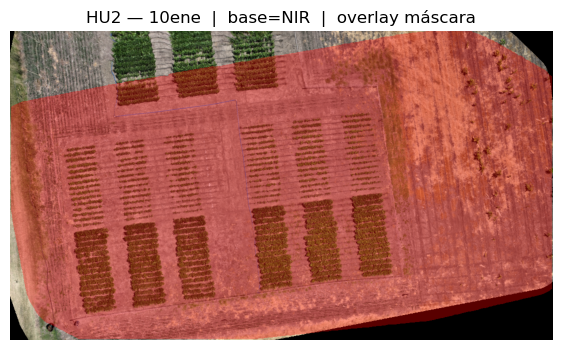

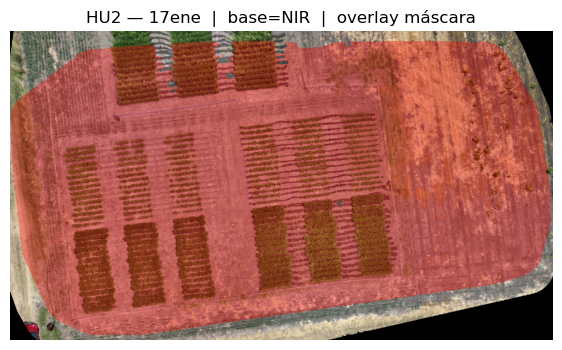

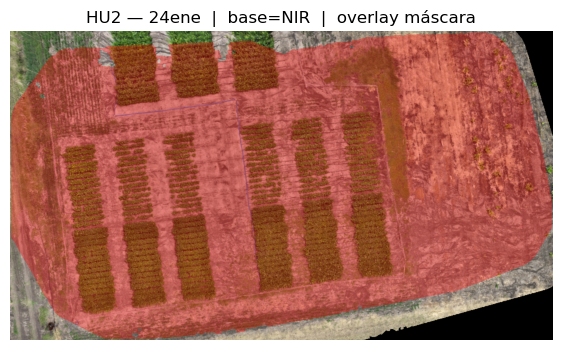

In [22]:
# %% 
masks, overlays = run_HU2_segmentacion(aligned, normalized)
